# GPON Network visualizations - Part 2

## Today's visualization

For our second visualization we have a "scatter plot". This is a no-brainier, plotting two variables against each other will always be insightful, nevertheless we can still find some interesting behavior in our network, specifically inside the PON port.

The scatter plot we will create today will show the client quantity per PON port on the __X__ axis, and the PON port traffic occupation in percentage, in the __Y__ axis. We chose to show the traffic occupation in percentage because it is easier to interpret, it is easier to say: "the PON port has a 14 % occupation", than: "the traffic occupation in the PON port is 350 Mbps", the former conveys the information in a more "human readable" context, than the latter.

---

## Again, no public data

Last time we established the fact that there is no public data available for this kind of exercises, but, we found a workaround for this fact, and it was creating our own synthetic data.
This time, we need to add a new variable to our last data schema: the percentage of PON port occupation. And again we will do it using the function "random.randint" from Python. Let's dive right in:

In [5]:
# Make all the imports needed
import pandas as pd
import numpy as np
from itertools import product
from random import randint, choice
import matplotlib.pyplot as plt
import seaborn as sns

# Make a preview of the dataset we need to create
df = pd.DataFrame(data=[[1,2,3,4,'model_A'],[5,6,7,8,'model_B']], columns=[['slot', 'port', 'client_qty','ocupation_%', 'model']])
df

,slot,port,client_qty,ocupation_%,model
0,1,2,3,4,model_A
1,5,6,7,8,model_B


The data can come in any form: csv, xlsx, etc., and it should consist of at least the columns showed in the previous dataframe: 'slot', 'port', 'client_qty', 'ocupation_%', 'model', and hopefuly each column name is self explanatory.

---

We will follow last time modus operandi:
1. Create a __class__ named OLT that will contain the information we need.
2. This class, after instantiated will try to imitate real data coming from a query done to a real OLT.
3. Instantiate many of this synthetic OLTs with their data to give the impresion of a large network, this also helps making the visualizations more engaging.
4. Use the synthetic dataset to create the plot.

To continue we need to introduce a new mechanic into the class, we will use this mechanic to simulate the traffic occupation inside the PON port by adding the product between the client quantity, and a "created KPI": client base speed (which we will add as a paremeter to the populate method of the OLT class), so each port should have more traffic if it has more clients, but, we also want to introduce some realism, and we will make this "client base speed" a random too, and introduce it into the __"create_olt_and_populate()"__ method of our OLT class.

In [6]:
class OLT:
    """ Define a class OLT that have the following attributes:
        - An "int" Board quantity (slot_qty) which represent the maximun slot count that the OLT has.
        - An "int" Port quantity per slot (port_per_slot) which represent the maximun port count per slot that the OLT has.
        - An "int" Maximun client quantity per pon port (max_client_qty) which represent the maximun client count per port per slot that the OLT has. """

    def __init__(self, slot_qty=16, port_per_slot=16):
        self.slot_qty = slot_qty
        self.port_per_slot = port_per_slot

    # Then we define a method that will create and populate each pon port of the OLT instance with a client quantity
    def create_olt_and_populate(self, max_client_qty, speeds):
        # We assign the model of the OLT at random, during the creation
        models = ['Model_A', 'Model_B', 'Model_C', 'Model_D']
        model = choice(models)
        # We define a list as population, to add to it the information as tuples (slot, port, client_qty, model)
        population = []
        slot_port_tuples = [(slot, port) for slot, port in product(range(1,self.slot_qty+1), range(1,self.port_per_slot+1))]

        for tupla in slot_port_tuples:
            clients = randint(0,max_client_qty)
            speed = [(clients * choice(speeds))/15 if clients > 0 else 0]
            population.append(tupla + (clients, *speed, model))

        # Then we create and return a Pandas DataFrame, in which each row represents "a PON port" with its information
        df = pd.DataFrame(population, columns=['slot', 'port', 'client_qty', 'ocupation_%', 'model'])

        return df

We now create the whole dataset, this time we will create:
* 350 OLTs.
* Each with a maximum of 64 clients per PON port.
* And we assign the __speeds__ variable to be an array that simulates different client base speeds, as we stated before. Remember we are trying to give some realism to this da*ta without intending to be statistically rigorous about the nature of the throughput dynamics of clients inside the PON port, that in it on itself could be subject to a chapter or two inside a book (remember Dynamic Bandwidth Allocation algorithm inside the PON port).

In [7]:
olt_qty = 350
max_client_qty = 64
speeds = np.arange(10, 20, 0.1)
concat_df = pd.concat([OLT().create_olt_and_populate(max_client_qty, speeds) for olt in range(olt_qty)])
concat_df

,slot,port,client_qty,ocupation_%,model
0,1,1,53,55.473333,Model_A
1,1,2,38,36.480000,Model_A
2,1,3,57,59.660000,Model_A
3,1,4,38,40.533333,Model_A
4,1,5,11,13.126667,Model_A
...,...,...,...,...,...
251,16,12,56,47.040000,Model_A
252,16,13,62,71.920000,Model_A
253,16,14,19,18.746667,Model_A
254,16,15,48,45.760000,Model_A


That easily we created a synthetic dataset of 89.600 PON ports with random client quantity, and traffic occupation for each one of it.

## Create the visualization

1. First, we calculate the average of the traffic occupation for the whole network:

In [8]:
mean = concat_df['ocupation_%'].mean()

2. Then, we create the scatter plot, with the client quantity as the __X__ axis, and the traffic occupation as __Y__ axis. we also assign the blue color to the points:

In [13]:
ax = concat_df.plot(kind='scatter', x='client_qty', y='ocupation_%', color='blue')
ax.axhline(mean, lw=8, color='green', label='Mean')
plt.show()

3. Finally we calculate the average of the traffic occupation, and calculate the x axis value for the __text__ that we draw with the mean line: 

In [10]:
# Calculate the mean of ocupation, and the x axis of the text
mean = concat_df['ocupation_%'].mean()
text_x = concat_df['client_qty'].max() / 10

Putting it all together:

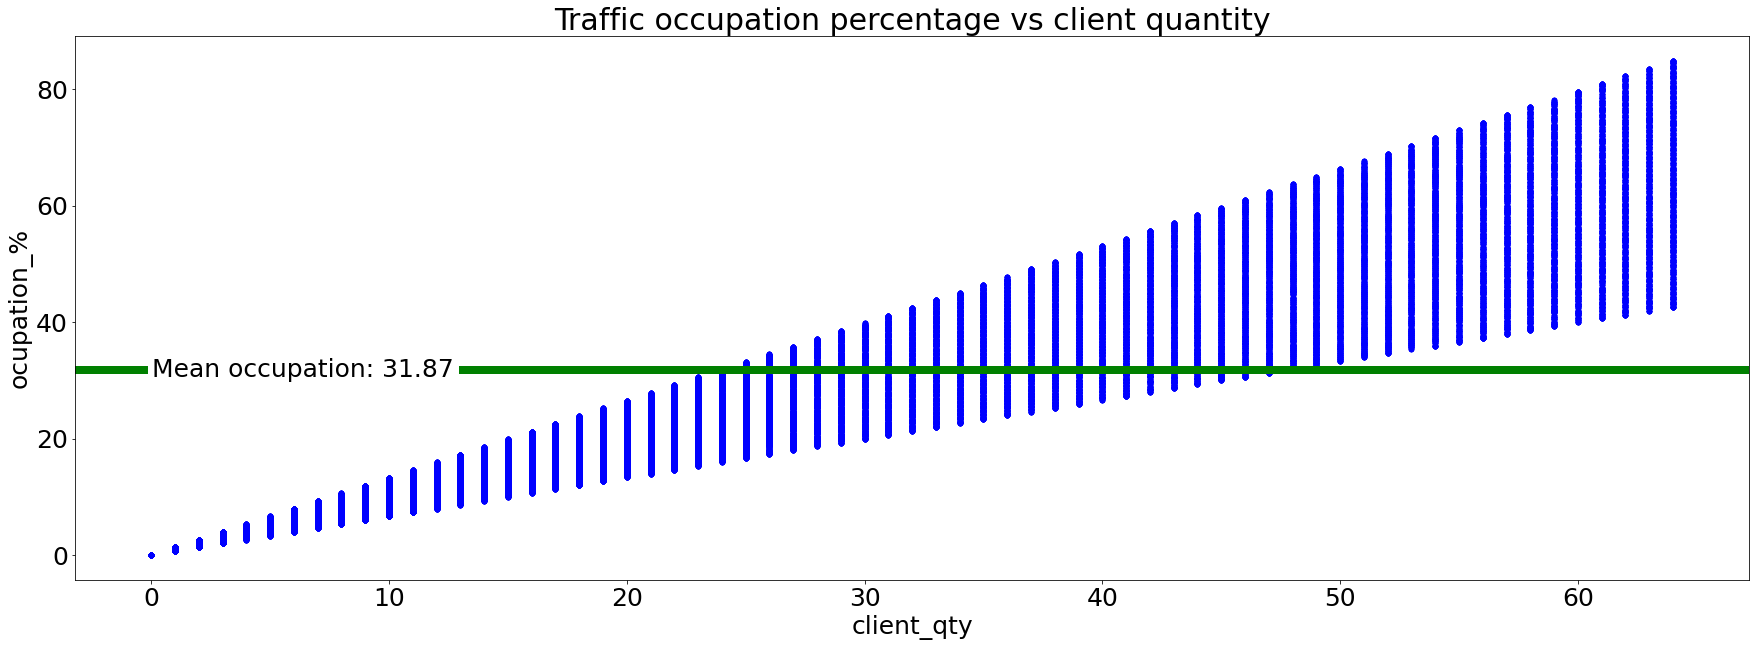

In [11]:
#from matplotlib.pyplot import annotate
plt.rcParams.update({'font.size':25, 'figure.figsize': (30,10)})

# Calculate the mean of ocupation, and the x axis of the text
mean = concat_df['ocupation_%'].mean()
text_x = concat_df['client_qty'].max() / 10

# Create the scatter plot, the horizontal line, and the text 
ax = concat_df.plot(kind='scatter', x='client_qty', y='ocupation_%', color='blue')
ax.axhline(mean, lw=8, color='green', label='Mean')
ax.text(text_x,mean, 'Mean occupation: {:.2f}'.format(mean), fontsize=25, va='center', ha='center', backgroundcolor='w')
ax.set_title('Traffic occupation percentage vs client quantity')
plt.show()

## Closing comments

* The first thing that we can see is that there seems to be a positive correlation between the variables (of course there is, we made it this way), but with your data, you might see some different relation between the variables:
    - One thing we've seen is that in most of the cases, when there are a few clients in a PON port (less than 10), they have a "free highway" (mainly because of DBA, in a oversimplification we can say that they're given a lot of bandwidth because there is few competition inside the PON port), and they have very high average traffic, so you might see that some PON ports, with few users, may have large traffic occupations, while others with more clients, have less bandwidth occupation.
    - So you may be able to spot if this condition is widespread in your network.
* Another key feature seen in this visualization, is the occupation "floor", by this, I mean the lowest points in each vertical line (which translates to every client quantity, for example, on 10 client quantity on the X axis, there is a vertical line that roughly goes from 10 to 15 % occupation) they go up as the client quantity increases, revealing a key condition of the data: "indeed, as the client quantity goes up, the lowest occupation of the ports goes up also":
    - With your data you might see this, and it would be interesting how "evident" is this feature in your data.
    - If overtime you see this "floor" increasse, this could mean a steady raise in the overall client average speed.
* The "mean" horizontal line also conveys a lot of information, because if this "mean line" is too high (although this could be subjective, how "high" is high? It varies from network to network, but for us in this setting, high is over 50 %) you might want to check the traffic as time series analysis:
    - A high mean could be telling you that the traffic bursts are very long, and that many PON ports are being over stressed.
* You could tweak this visualization in many ways with your data:
    - You could plot the averages of each PON port in an entire month, so you can check the average occupation monthly (I don't do it here because it would only draw a diagonal straight line, which doesn't tell a lot of information). And, in this way you could check the specific relationship between the client quantity and the traffic over a month.
    - You could plot two-time frames (maybe two months, and of course, use different colors for each month) and check if there is too much variation between the time steps. If there is a lot of variation in the average, you might want to check if there has been changes in the customer speed plans (I'll let you think about how this could happen).

I hope this was useful for you, and that you are looking forward for the next visualization!
